<a href="https://colab.research.google.com/github/wakamatsuikuma/MEMO_causal_analysis_by_python/blob/main/%E7%AC%AC5%E7%AB%A0_1_%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%82%92%E7%94%A8%E3%81%84%E3%81%9F%E5%9B%A0%E6%9E%9C%E6%8E%A8%E8%AB%96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  メモ
- 樹木系モデルのとりあえずの損失関数  
分類:情報利得(Infomation gain)の最大化。つまり分岐後各ノードのジニ不純度の和の最小化。つまり分岐後各ノードにできるだけラベル純度が高くなること。（数式的に割合が多いクラスの影響が大きそうなので、クラス数が少ない<どれだけ任意のクラスの割合が多いか　が重要。多分。）  
回帰:二乗誤差の最小化。つまり分岐後各ノードの二乗誤差の和が小さくなる様になる。つまり、同じ様な値がノードに集まった方がいい。外れ値の影響が大きいので、外れ値はある程度一つに固まりそう。なので、外れ値に強そう。
- ランダムフォレストについて  
分類：特徴量(ルート分)とサンプル(重複あり)をランダムに取得して、一つの決定木をつくる。推論時の分類確率の求め方は、各決定木においてたどりついたノードのクラス割合をもたせて、全ての決定木での比とする。  
回帰：サンプルのみ重複ありで取得して、1つの決定木をつくる。推論値の求め方は、各決定木での回帰推論値(たどりついたノードでの平均)の全体平均とする。

# ライブラリのインポートや設定

In [ ]:
# 乱数のシードを設定
import random
import numpy as np

np.random.seed(1234)
random.seed(1234)


In [ ]:
# 使用するパッケージ（ライブラリと関数）を定義
# 標準正規分布の生成用
from numpy.random import *

# グラフの描画用
import matplotlib.pyplot as plt

# SciPy 平均0、分散1に正規化（標準化）関数
import scipy.stats

# シグモイド関数をimport
from scipy.special import expit

# その他
import pandas as pd

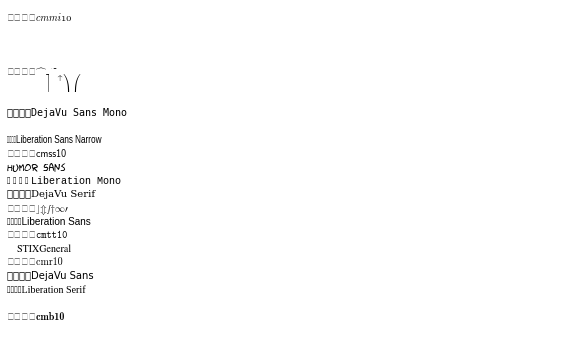

In [ ]:
# 日本語が表示できるフォントの確認

import matplotlib
# フォントを全て読み込み
fonts = set([f.name for f in matplotlib.font_manager.fontManager.ttflist])
 
# 描画領域のサイズ調整
plt.figure(figsize=(10,len(fonts)/4))
 
# フォントの表示
for i, font in enumerate(fonts):
    plt.text(0, i, f"日本語：{font}", fontname=font)
    
# 見やすいように軸を消す
plt.ylim(0, len(fonts))
plt.axis("off")
    
plt.show()

In [ ]:
# 日本語表示できるフォントに変更
plt.rcParams['font.family'] = "STIXGeneral"

# データの生成

In [ ]:
# データ数
num_data = 200
# 年齢
x_1 = randint(15, 76, num_data)  # 15から75歳の一様乱数
# 性別（0を女性、1を男性とします）
x_2 = randint(0, 2, num_data)  # 0か1の乱数


# テレビCMを見たかどうか
# ノイズの生成
e_z = randn(num_data)
# シグモイド関数に入れる部分
z_base = x_1 + (1-x_2)*10 - 40 + 5*e_z
# シグモイド関数を計算
z_prob = expit(0.1*z_base)
# テレビCMを見たかどうかの変数（0は見ていない、1は見た）
Z = np.array([])
for i in range(num_data):
    Z_i = np.random.choice(2, size=1, p=[1-z_prob[i], z_prob[i]])[0]
    Z = np.append(Z, Z_i)


# 購入量Yを作成
# ノイズの生成
e_y = randn(num_data)
Y = -x_1 + 30*x_2 + 10*Z + 80 + 10*e_y

# データをまとめた表を作成し、平均値を比べる
df = pd.DataFrame({'年齢': x_1,
                   '性別': x_2,
                   'CMを見た': Z,
                   '購入量': Y,
                   })

# 先頭を表示
display(df.head())
# 平均値を比べる
print(df[df["CMを見た"] == 1.0].mean())
print("--------")
print(df[df["CMを見た"] == 0.0].mean())


,年齢,性別,CMを見た,購入量
0,61,1,1.0,39.004757
1,26,0,0.0,51.188840
2,21,0,1.0,60.584305
3,38,1,1.0,76.097415
4,33,1,0.0,84.892018


年齢       53.625954
性別        0.564885
CMを見た     1.000000
購入量      54.338318
dtype: float64
--------
年齢       33.101449
性別        0.623188
CMを見た     0.000000
購入量      65.846197
dtype: float64


# 決定木で分類
- "CMを見たかどうか"を予測する

In [ ]:
# scikit-learnから決定木の分類をimport
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from sklearn.tree import DecisionTreeClassifier, plot_tree

# データを訓練と検証に分割する
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split


# 説明変数
X = df[["年齢", "性別"]]

# 被説明変数（目的変数）
Z = df["CMを見た"]

# データを訓練と検証に分割
X_train, X_val, Z_train, Z_val = train_test_split(
    X, Z, train_size=0.6, random_state=0)

# 学習と性能確認
clf1 = DecisionTreeClassifier(max_depth=1, random_state=0)
clf1.fit(X_train, Z_train)
print("深さ1の性能：", clf1.score(X_val, Z_val))  # 正解率を表示

# 学習と性能確認
clf2 = DecisionTreeClassifier(max_depth=2, random_state=0)
clf2.fit(X_train, Z_train)
print("深さ2の性能：", clf2.score(X_val, Z_val))  # 正解率を表示

# 学習と性能確認
clf3 = DecisionTreeClassifier(max_depth=3, random_state=0)
clf3.fit(X_train, Z_train)
print("深さ3の性能：", clf3.score(X_val, Z_val))  # 正解率を表示

深さ1の性能： 0.8
深さ2の性能： 0.8
深さ3の性能： 0.7375


In [ ]:
X_train.columns

Index(['年齢', '性別'], dtype='object')

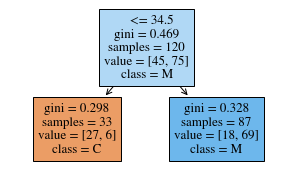

In [ ]:
plt.figure(figsize=(5, 3))
plot_tree(clf1, feature_names=["年齢", "性別"], class_names="CMを見た", filled=True)
plt.show()

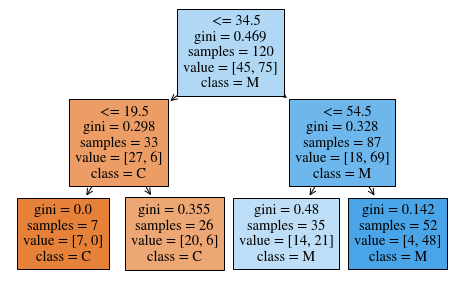

In [ ]:
plt.figure(figsize=(8, 5))
plot_tree(clf2, feature_names=X_train.columns, class_names=Z_train.name, filled=True)
plt.show()

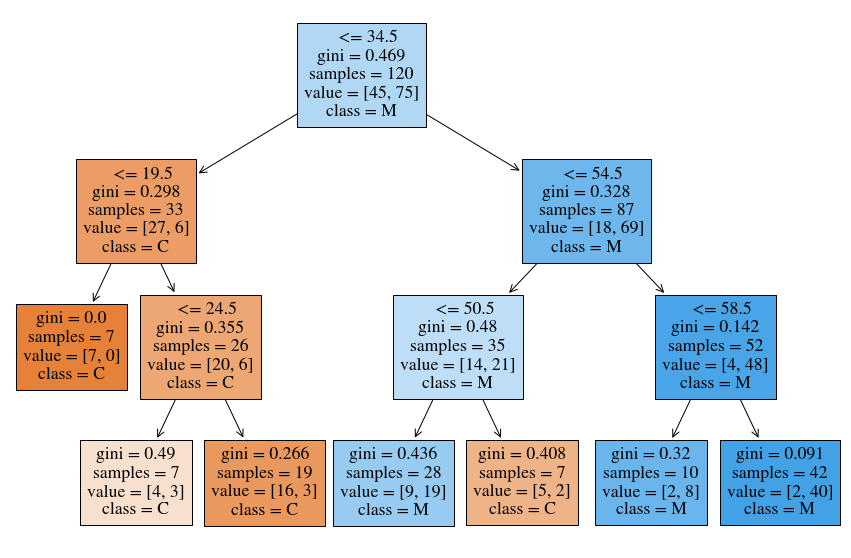

In [ ]:
plt.figure(figsize=(15, 10))
plot_tree(clf3, feature_names=X_train.columns, class_names=Z_train.name, filled=True)
plt.show()

# 決定木で回帰
- 決定木で購入量を回帰予測するモデルを構築

In [ ]:
# scikit-learnから決定木の回帰をimport
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

# データを訓練と検証に分割する
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split


# 説明変数
X = df[["年齢", "性別"]]

# 被説明変数（目的変数）
Y = df["購入量"]

# データを訓練と検証に分割
X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, train_size=0.6, random_state=0)

# 学習と性能確認
reg1 = DecisionTreeRegressor(max_depth=2, random_state=0)
reg1 = reg1.fit(X_train, Y_train)
print("深さ2の性能：", reg1.score(X_val, Y_val))  # 決定係数R2を表示

# 学習と性能確認
reg2 = DecisionTreeRegressor(max_depth=3, random_state=0)
reg2 = reg2.fit(X_train, Y_train)
print("深さ3の性能：", reg2.score(X_val, Y_val))  # 決定係数R2を表示

# 学習と性能確認
reg3 = DecisionTreeRegressor(max_depth=4, random_state=0)
reg3 = reg3.fit(X_train, Y_train)
print("深さ4の性能：", reg3.score(X_val, Y_val))  # 決定係数R2を表示


深さ2の性能： 0.7495462106592086
深さ3の性能： 0.752661960025979
深さ4の性能： 0.7213350893818757


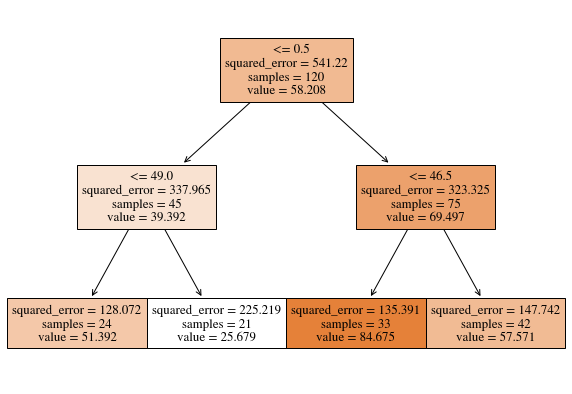

In [ ]:
plt.figure(figsize=(10, 7))
plot_tree(reg1, feature_names=X_train.columns, class_names=Z_train.name, filled=True)
plt.show()

In [ ]:
# plt.figure(figsize=(15, 10))
# plot_tree(reg3, feature_names=X_train.columns, class_names=Z_train.name, filled=True)
# plt.show()

# ランダムフォレストで分類
- "CMを見たかどうか"を分類予測する

In [ ]:
# scikit-learnからランダムフォレストの分類をimport
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# 説明変数
X = df[["年齢", "性別"]]

# 被説明変数（目的変数）
Z = df["CMを見た"]

# データを訓練と検証に分割
X_train, X_val, Z_train, Z_val = train_test_split(
    X, Z, train_size=0.6, random_state=0)

# 学習と性能確認
clf = RandomForestClassifier(max_depth=1, random_state=0)
clf.fit(X_train, Z_train)
print("深さ1の性能：", clf.score(X_val, Z_val))  # 正解率を表示

# 学習と性能確認
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, Z_train)
print("深さ2の性能：", clf.score(X_val, Z_val))  # 正解率を表示

# 学習と性能確認
clf = RandomForestClassifier(max_depth=3, random_state=0)
clf.fit(X_train, Z_train)
print("深さ3の性能：", clf.score(X_val, Z_val))  # 正解率を表示


深さ1の性能： 0.8
深さ2の性能： 0.7625
深さ3の性能： 0.7625


# ランダムフォレストで回帰
 - 購入量を回帰予測するモデルを構築

In [ ]:
# scikit-learnから決定木の回帰をimport
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html?highlight=randomforest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


# 説明変数
X = df[["年齢", "性別"]]

# 被説明変数（目的変数）
Y = df["購入量"]

# データを訓練と検証に分割
X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, train_size=0.6, random_state=0)

# 学習と性能確認
reg = RandomForestRegressor(max_depth=2, random_state=0)
reg = reg.fit(X_train, Y_train)
print("深さ2の性能：", reg.score(X_val, Y_val))  # 決定係数R2を表示

# 学習と性能確認
reg = RandomForestRegressor(max_depth=3, random_state=0)
reg = reg.fit(X_train, Y_train)
print("深さ3の性能：", reg.score(X_val, Y_val))  # 決定係数R2を表示

# 学習と性能確認
reg = RandomForestRegressor(max_depth=4, random_state=0)
reg = reg.fit(X_train, Y_train)
print("深さ4の性能：", reg.score(X_val, Y_val))  # 決定係数R2を表示

深さ2の性能： 0.7714554078545842
深さ3の性能： 0.7695259659039547
深さ4の性能： 0.7560359732053176
